# HR-аналитика
Нам передали данные с характеристиками сотрудников компании.

***Описание данных:*** 5 CSV-файлов с данными с признаками сотрудников и результатами тест-опросника. О качестве данных ничего неизвестно, так что понадобится провести их обзор и подготовку.

*Описание датасетов:*

- `train_job_satisfaction_rate.csv` - тренировочная выборка для первой задачи;
- `test_features.csv` - входные признаки тестовой выборки для обеих задач;
- `test_target_job_satisfaction_rate.csv` - целевой признак тестовой выборки для первой задачи;
- `train_quit.csv` - тренировочная выборка для второй задачи;
- `test_target_quit.csv` - целевой признак тестовой выборки для второй задачи.

*Описание признаков:*

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак первой задачи;
- `quit` - увольнение сотрудника из компании, целевой признак второй задачи.

***Цель исследования:*** Перед нами стоит 2 задачи:
- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

***Ход исследования:*** Планируется 2 задачи по 6 и 7 этапов соответственно с оформлением общих выводов:

**Задача 1:** предсказание уровня удовлетворённости сотрудника:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Подготовка данных
- Обучение моделей
- Выводы

**Задача 2:** предсказание увольнения сотрудника из компании:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Добавление нового входного признака
- Подготовка данных
- Обучение модели
- Выводы

In [1]:
!pip install phik
!pip install -U scikit-learn
!pip install matplotlib==3.7.0 -q

In [2]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, make_scorer

from phik.report import plot_correlation_matrix
from phik import report

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [3]:
# Откроем и изучим train_job_satisfaction_rate.csv.
train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_sat.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
# Откроем и изучим test_features.csv.
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
# Откроем и изучим test_target_job_satisfaction_rate.csv.
test_sat = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_sat.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Промежуточный вывод:** Видим данные с характеристиками сотрудников компании. Данные соответствуют описанию задачи и общему оформлению с правильными типами данных. Обзор данных методом info() выявил пропуски.

### Предобработка данных

In [9]:
# Проверим датафреймы на явные дубликаты.
train_sat.duplicated().sum()

0

In [10]:
test_features.duplicated().sum()

0

In [11]:
test_sat.duplicated().sum()

0

In [12]:
# Проверим датафреймы на неявные дубликаты и опечатки.
train_sat['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [13]:
train_sat['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [14]:
train_sat['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [15]:
train_sat['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [16]:
train_sat['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [17]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [18]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [19]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [20]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [21]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [22]:
# Исправим опечатки и заполним пробелы.
train_sat['level'] = train_sat['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [23]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [24]:
# Заполним пропуски, используя пайплайн.
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [25]:
nan_cols = ['dept', 'level', 'workload']
train_sat[nan_cols] = imputer_pipe.fit_transform(train_sat[nan_cols])
test_features[nan_cols] = imputer_pipe.transform(test_features[nan_cols])

**Промежуточный вывод:** В ходе проверки на дубликаты явные повторы обнаружены не были. Пропуски заполнили в пайплайне. Данные приведены к одному правильному виду и готовы к работе.

### Исследовательский анализ данных

#### train_job_satisfaction_rate.csv

In [26]:
# Рассмотрим статистические данные датафрейма.
train_sat.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


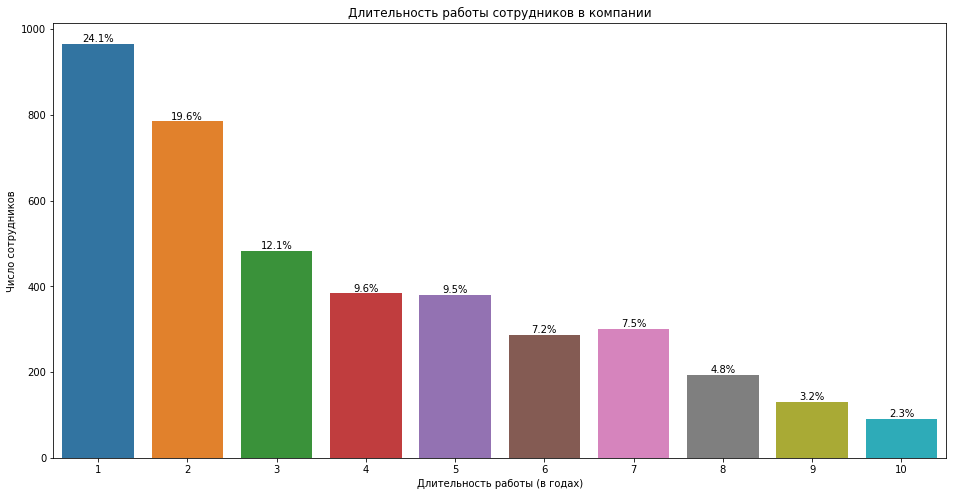

In [138]:
# Построим графики для количественных признаков датафрейма.
# Построим столбчатую диаграмму распределения длительности работы сотрудников в компании.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='employment_years', data = train_sat)
total = train_sat['employment_years'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Длительность работы сотрудников в компании')
plt.xlabel('Длительность работы (в годах)')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим что сотрудников, работающих в компании дольше, меньше, за исключением 6 и 7 лет. Возможно, это нормально для заказчика. Сказываться может как постепенное расширение, так и текучесть кадров.

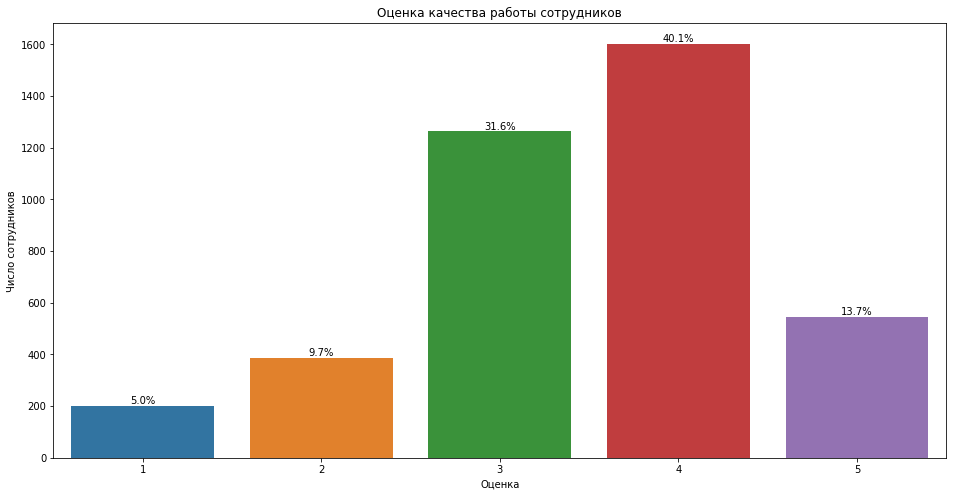

In [139]:
# Построим столбчатую диаграмму распределения оценок качества работы сотрудников, данных руководителями.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='supervisor_evaluation', data = train_sat)
total = train_sat['supervisor_evaluation'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Оценка качества работы сотрудников')
plt.xlabel('Оценка')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим, что самая частая оценка сотрудников - 4. Сотрудников, оцененных руководителями ниже чем на 3 балла около 600 из 4000.

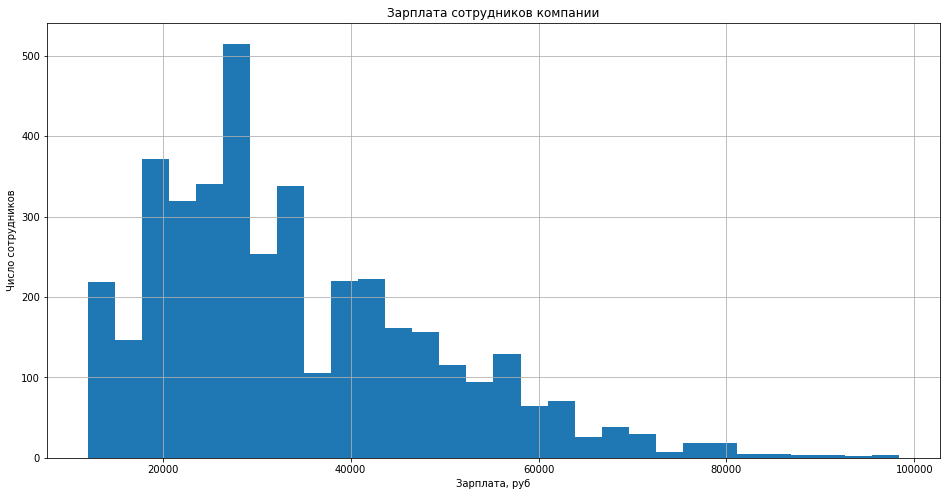

In [29]:
# Построим гистограмму распределения зарплат сотрудников компании.
train_sat['salary'].hist(figsize=(16, 8), bins=30)
plt.title('Зарплата сотрудников компании')
plt.xlabel('Зарплата, руб')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение зарплаты, похожее на нормальное со сдвигом влево. Медиана 30 тысяч рублей. Имеются выбросы, которые мы не будем убирать в виду того, что они действительно возможны.

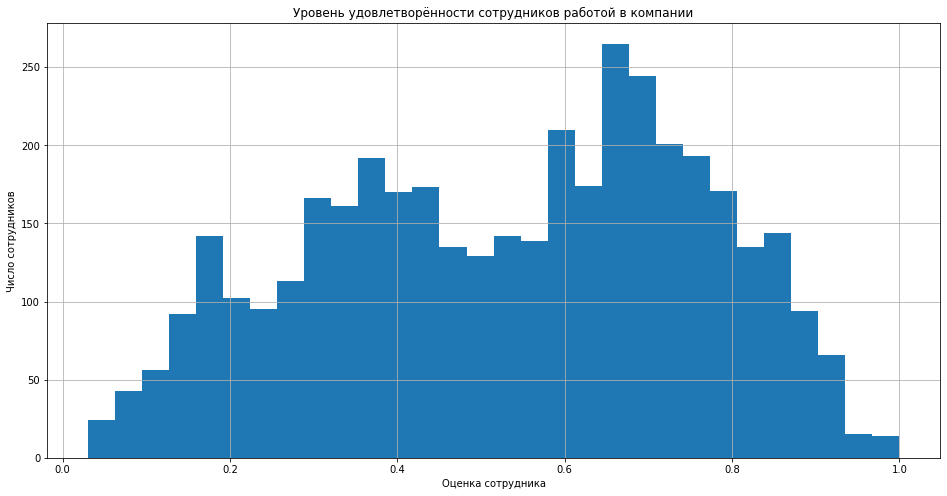

In [30]:
# Построим гистограмму уровня удовлетворённости сотрудников работой в компании.
train_sat['job_satisfaction_rate'].hist(figsize=(16, 8), bins=30)
plt.title('Уровень удовлетворённости сотрудников работой в компании')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение удовлетворенности, похожее на нормальное со сдвигом вправо, без необычных выбросов.

In [31]:
# Проанализируем распределение категоральных признаков.
# Начнем с отделов, в которых работают сотрудники.
train_sat['dept'].value_counts()

sales         1518
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

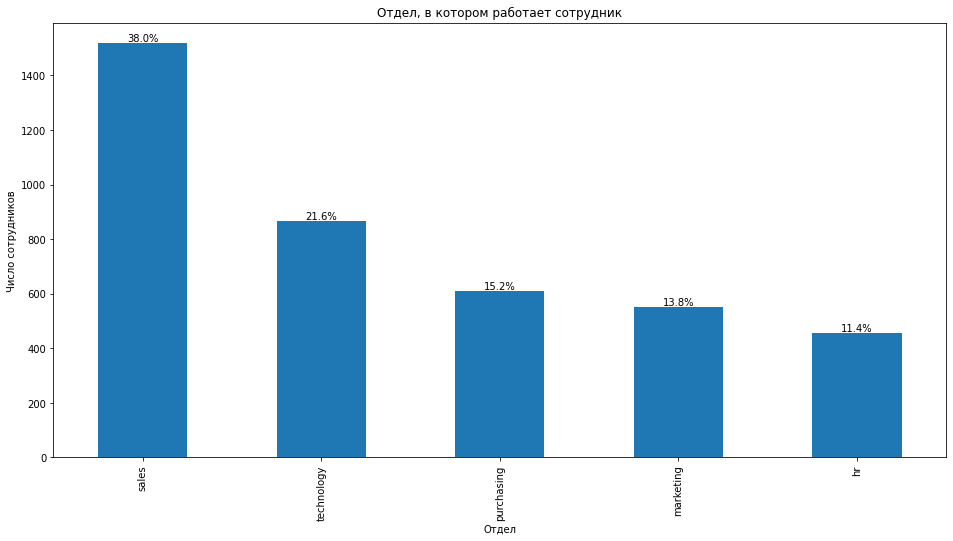

In [140]:
# Построим столбчатую диаграмму распределения по отделам.
plt.figure(figsize=(16, 8))
ax = train_sat['dept'].value_counts().plot(kind='bar')
total = train_sat['dept'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Отдел, в котором работает сотрудник')
plt.xlabel('Отдел')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим, что самым большим отделом является отдел продаж. Наименьшим является HR.

In [33]:
# Рассмотрим уровень занимаемой сотрудниками должности.
train_sat['level'].value_counts()

junior    1898
middle    1744
senior     358
Name: level, dtype: int64

<Axes: title={'center': 'Уровень занимаемой сотрудниками должности'}, ylabel='level'>

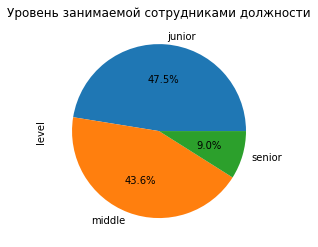

In [34]:
# Построим круговую диаграмму распределения уровней занимаемой должности.
train_sat['level'].value_counts().plot(kind='pie', title='Уровень занимаемой сотрудниками должности', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 47.5 - junior, 43.6 - middle и 9 - senior.

In [35]:
# Рассмотрим уровень загруженности сотрудников.
train_sat['workload'].value_counts()

medium    2066
low       1200
high       734
Name: workload, dtype: int64

<Axes: title={'center': 'Уровень загруженности сотрудников'}, ylabel='workload'>

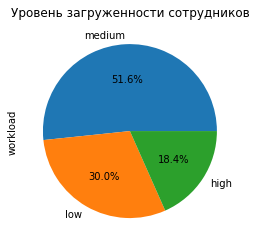

In [36]:
# Построим круговую диаграмму распределения уровней загруженности.
train_sat['workload'].value_counts().plot(kind='pie', title='Уровень загруженности сотрудников', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 51.6 - средний, 30 - низкий и 18.4 - высокий уровень.

In [37]:
# Рассмотрим распределение повышений в прошлом году.
train_sat['last_year_promo'].value_counts()

no     3880
yes     120
Name: last_year_promo, dtype: int64

<Axes: title={'center': 'Распределение повышений в прошлом году'}, ylabel='last_year_promo'>

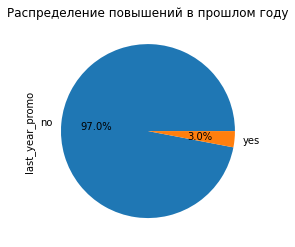

In [38]:
# Построим круговую диаграмму распределения повышений.
train_sat['last_year_promo'].value_counts().plot(kind='pie', title='Распределение повышений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 97 к 3 с перевесом в пользу отсутствия повышения.

In [39]:
# Рассмотрим распределение нарушений сотрудниками трудового договора за последний год.
train_sat['last_year_violations'].value_counts()

no     3441
yes     559
Name: last_year_violations, dtype: int64

<Axes: title={'center': 'Распределение нарушений в прошлом году'}, ylabel='last_year_violations'>

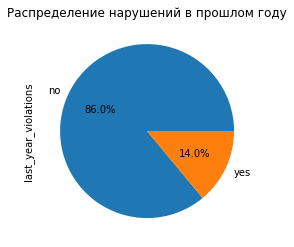

In [40]:
# Построим круговую диаграмму распределения повышений.
train_sat['last_year_violations'].value_counts().plot(kind='pie',
                                                      title='Распределение нарушений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 86 к 14 с перевесом в пользу отсутствия нарушений.

#### test_features.csv

In [41]:
# Рассмотрим статистические данные датафрейма.
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


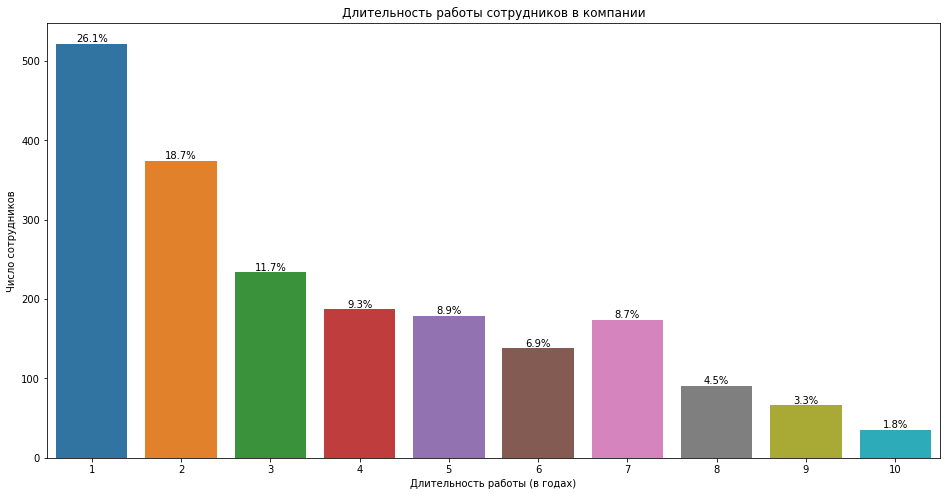

In [141]:
# Построим графики для количественных признаков датафрейма.
# Построим столбчатую диаграмму распределения длительности работы сотрудников в компании.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='employment_years', data = test_features)
total = test_features['employment_years'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Длительность работы сотрудников в компании')
plt.xlabel('Длительность работы (в годах)')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающее подозрений, похожее на тренировочные данные.

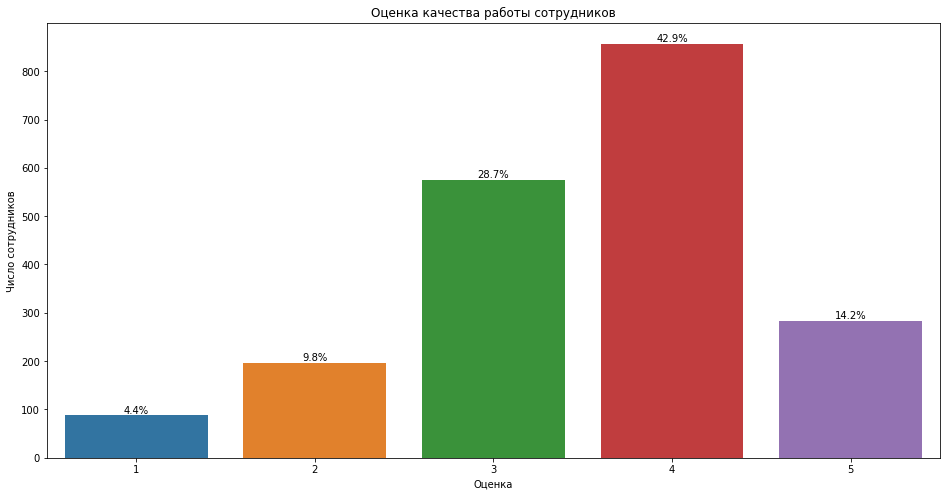

In [142]:
# Построим столбчатую диаграмму распределения оценок качества работы сотрудников, данных руководителями.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='supervisor_evaluation', data = test_features)
total = test_features['supervisor_evaluation'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Оценка качества работы сотрудников')
plt.xlabel('Оценка')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающие подозрений, похожее на тренировочные данные.

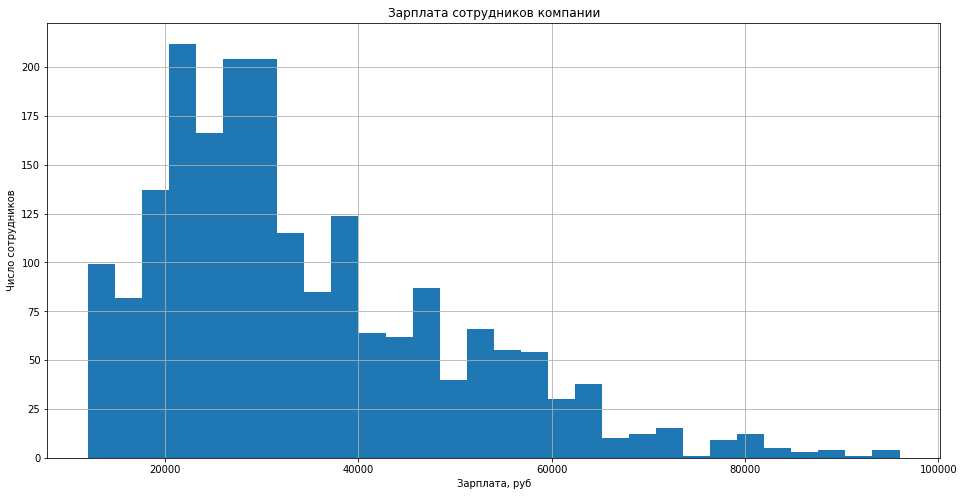

In [44]:
# Построим гистограмму распределения зарплат сотрудников компании.
test_features['salary'].hist(figsize=(16, 8), bins=30)
plt.title('Зарплата сотрудников компании')
plt.xlabel('Зарплата, руб')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающие подозрений, похожее на тренировочные данные, с той же медианой.

In [45]:
# Проанализируем распределение категоральных признаков.
# Начнем с отделов, в которых работают сотрудники.
test_features['dept'].value_counts()

sales         766
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

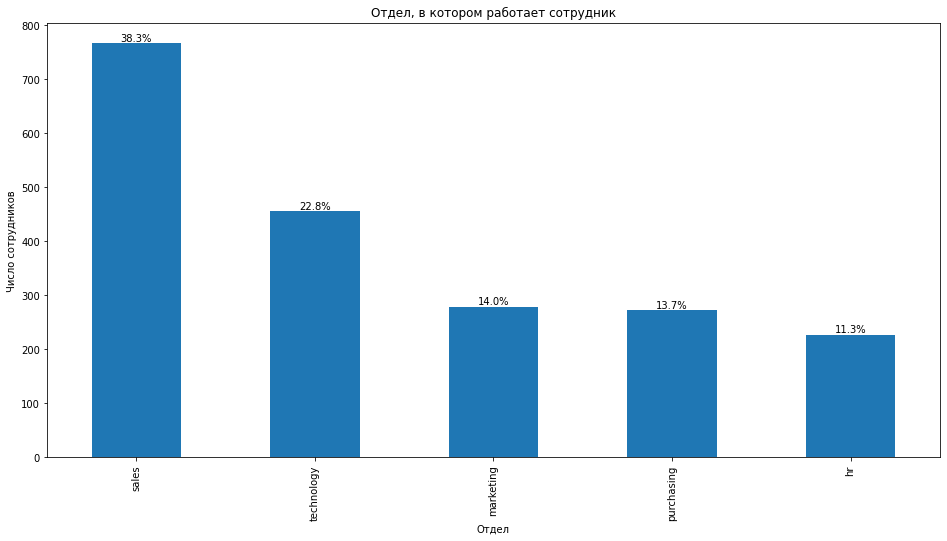

In [143]:
# Построим столбчатую диаграмму распределения по отделам.
plt.figure(figsize=(16, 8))
ax = test_features['dept'].value_counts().plot(kind='bar')
total = test_features['dept'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Отдел, в котором работает сотрудник')
plt.xlabel('Отдел')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим, что самым большим отделом, так же как и в тренировочных данных, является отдел продаж. Наименьшим является HR.

In [47]:
# Рассмотрим уровень занимаемой сотрудниками должности.
test_features['level'].value_counts()

junior    975
middle    854
senior    171
Name: level, dtype: int64

<Axes: title={'center': 'Уровень занимаемой сотрудниками должности'}, ylabel='level'>

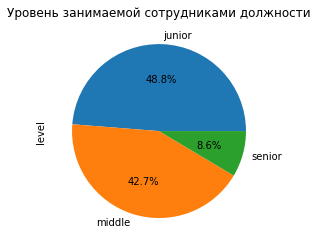

In [48]:
# Построим круговую диаграмму распределения уровней занимаемой должности.
test_features['level'].value_counts().plot(kind='pie', title='Уровень занимаемой сотрудниками должности', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 48.8 - junior, 42.7 - middle и 8.6 - senior.

In [49]:
# Рассмотрим уровень загруженности сотрудников.
test_features['workload'].value_counts()

medium    1044
low        593
high       363
Name: workload, dtype: int64

<Axes: title={'center': 'Уровень загруженности сотрудников'}, ylabel='workload'>

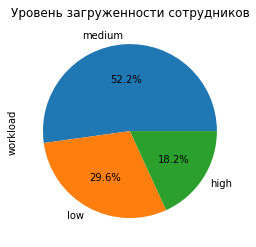

In [50]:
# Построим круговую диаграмму распределения уровней загруженности.
test_features['workload'].value_counts().plot(kind='pie', title='Уровень загруженности сотрудников', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 52.2 - средний, 29.6 - низкий и 18.2 - высокий уровень.

In [51]:
# Рассмотрим распределение повышений в прошлом году.
test_features['last_year_promo'].value_counts()

no     1937
yes      63
Name: last_year_promo, dtype: int64

<Axes: title={'center': 'Распределение повышений в прошлом году'}, ylabel='last_year_promo'>

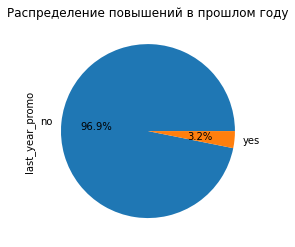

In [52]:
# Построим круговую диаграмму распределения повышений.
test_features['last_year_promo'].value_counts().plot(kind='pie',
                                                     title='Распределение повышений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 96.8 к 3.2 с перевесом в пользу отсутствия повышения.

In [53]:
# Рассмотрим распределение нарушений сотрудниками трудового договора за последний год.
test_features['last_year_violations'].value_counts()

no     1738
yes     262
Name: last_year_violations, dtype: int64

<Axes: title={'center': 'Распределение нарушений в прошлом году'}, ylabel='last_year_violations'>

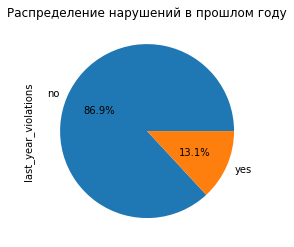

In [54]:
# Построим круговую диаграмму распределения повышений.
test_features['last_year_violations'].value_counts().plot(kind='pie',
                                                      title='Распределение нарушений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 86.9 к 13.1 с перевесом в пользу отсутствия нарушений.

#### test_target_job_satisfaction_rate.csv

In [55]:
# Рассмотрим статистические данные датафрейма.
test_sat.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


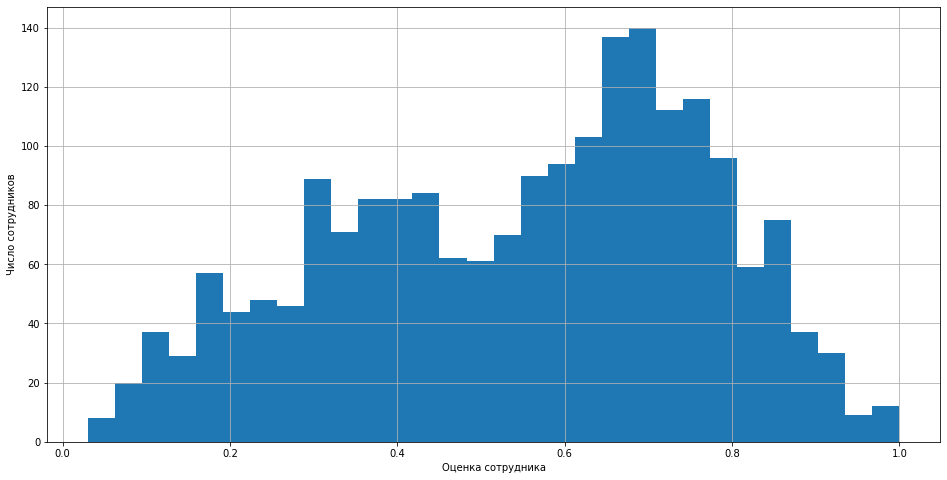

In [56]:
# Построим гистограмму уровня удовлетворённости сотрудника работой в компании.
test_sat['job_satisfaction_rate'].hist(figsize=(16, 8), bins=30)
plt.xlabel('Оценка сотрудника')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающее подозрений, похожее на схожее из тренировочных данных.

#### Корреляционный анализ тренировочной выборки

In [57]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции признаков тренировочной выборки.
cdf = train_sat.drop(columns=['id'])

# Составим список интервальных признаков.
interval_cols = ['salary', 'job_satisfaction_rate']

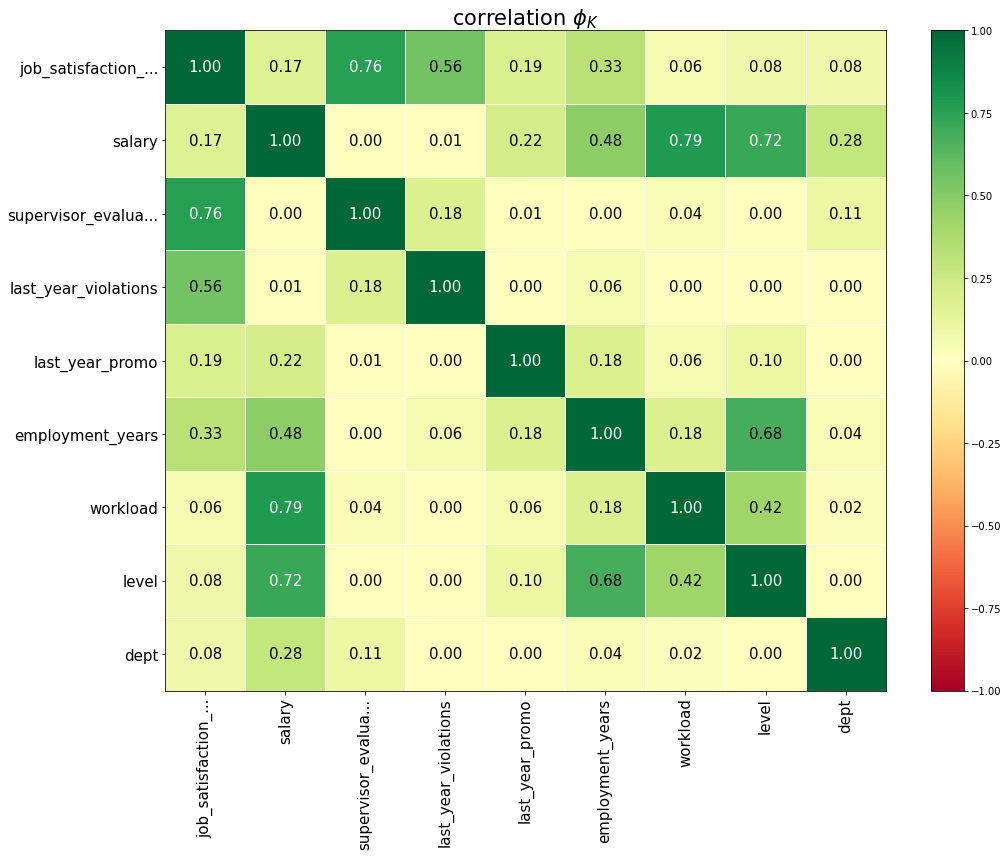

In [58]:
# Вычислим коэффициенты корреляции phi для датафрейма.
phik_overview = cdf.phik_matrix(interval_cols=interval_cols)

# Визуализируем тепловую карту коэффициентов корреляции.
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Описание данных:** Видим корреляцию уровня удовлетворённости с оценкой руководителя, загруженности с зарплатой и уровня должности с зарплатой, однако, говорить о мультиколлинеарности рано.

#### Корреляционный анализ тестовой выборки

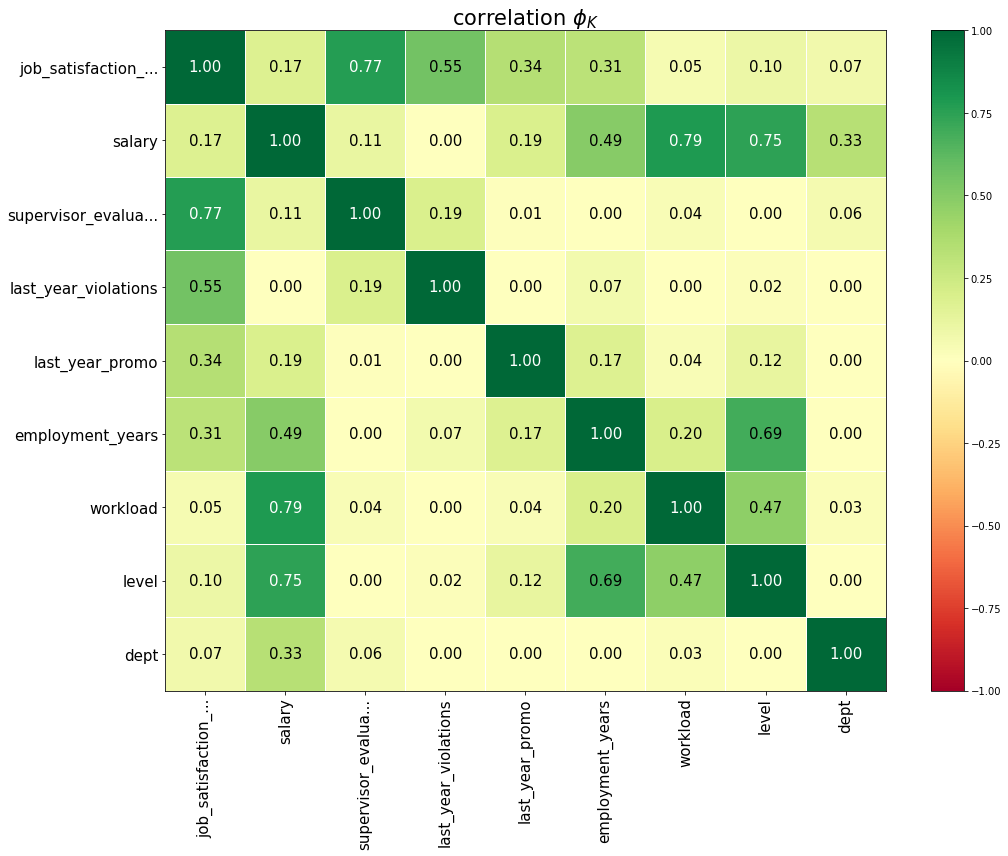

In [59]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции признаков тестовой выборки.
ddf = test_features.merge(test_sat, on='id', how='inner').drop(columns=['id'])

# Составим список интервальных признаков.
interval_cols = ['salary', 'job_satisfaction_rate']

# Вычислим коэффициенты корреляции phi для датафрейма.
phik_overview = ddf.phik_matrix(interval_cols=interval_cols)

# Визуализируем тепловую карту коэффициентов корреляции.
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Описание данных:** Видим корреляцию уровня удовлетворённости с оценкой руководителя, загруженности с зарплатой и уровня должности с зарплатой, как и в тренировочных данных. Однако, говорить о мультиколлинеарности рано.

**Промежуточный вывод:** В целом данные выглядят нормально распределенными, без необычных выбросов. Тем не менее, их надо кодировать и масштабировать.

### Подготовка данных

In [60]:
RANDOM_STATE = 42
# Обозначим выборки.
X = train_sat.drop(['id', 'job_satisfaction_rate'], axis = 1)

In [61]:
y = train_sat['job_satisfaction_rate']

In [62]:
# Создадим списки с названиями признаков.
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

In [63]:
# Создадим пайплайн для подготовки признаков из списка ohe_columns.
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [64]:
# Создадим пайплайн для подготовки признаков из списка ord_columns.
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [65]:
# Создадим пайплайн для подготовки признаков из списка num_columns.
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'minMaxScaler',
            MinMaxScaler()
        )
    ]
)

In [66]:
# Создадим общий пайплайн для подготовки данных.
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

### Обучение моделей

In [67]:
# Создадим итоговый пайплайн: подготовка данных и модель.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [68]:
# Создадим param_grid.
param_grid= [
    # Словарь для модели DecisionTreeRegressor():
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range (1, 20),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели LinearRegression():
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [69]:
# Создадим функцию для новой метрики SMAPE.
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape_score, greater_is_better = False)

In [70]:
# Подберем лучшую модель и ее параметры.
search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
search.fit(X, y)

print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print(f'Метрика лучшей модели на тренировочной выборке: {-search.best_score_}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [71]:
# Проверим модель на тестовой выборке. Используем датафрейм, который объединяли для корреляционного анализа.
X_test = ddf.drop(['job_satisfaction_rate'], axis = 1)
y_test = ddf['job_satisfaction_rate']

# Считаем метрику SMAPE.
y_predict = search.best_estimator_.predict(X_test)
smape_score(np.array(y_test), y_predict)

13.463614560644302

### Выводы

Качество модели, согласно условию, подбирали, основываясь на метрике SMAPE (symmetric mean absolute percentage error), для которой создали свою функцию. Критерий успеха: SMAPE ≤15 на тестовой выборке.

В результате рандомизированного поиска по параметрам отобрали модель DecisionTreeRegressor с параметрами max_depth=19, min_samples_leaf=2, min_samples_split=9. Эта модель показала лучшие результаты метрики SMAPE на тренировочной выборке: 13.46. Когда в данных больше категориальных признаков, чем количественных, лучше использовать модель дерева решений, чем линейной регрессии.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [72]:
# Откроем и изучим train_quit.csv.
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [73]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [74]:
# Откроем и изучим test_test_target_quit.csv.
test_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [75]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Промежуточный вывод:** Видим данные с характеристиками сотрудников компании. Данные соответствуют описанию задачи и общему оформлению с правильными типами данных. Обзор данных методом info() не выявил пропуски. Учитываем, что датасет test_features.csv тот же, что и в первой задаче, дополнительно рассматривать и обрабатывать его не будем.

### Предобработка данных

In [76]:
# Проверим датафреймы на явные дубликаты.
train_quit.duplicated().sum()

0

In [77]:
test_quit.duplicated().sum()

0

In [78]:
# Проверим датафреймы на неявные дубликаты и опечатки.
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [79]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [80]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [81]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [82]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [83]:
# Исправим опечатки.
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

**Промежуточный вывод:** В ходе проверки на дубликаты явные повторы обнаружены не были. Данные приведены к одному правильному виду и готовы к работе.

### Исследовательский анализ данных

#### train_quit.csv

In [84]:
# Рассмотрим статистические данные датафрейма.
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


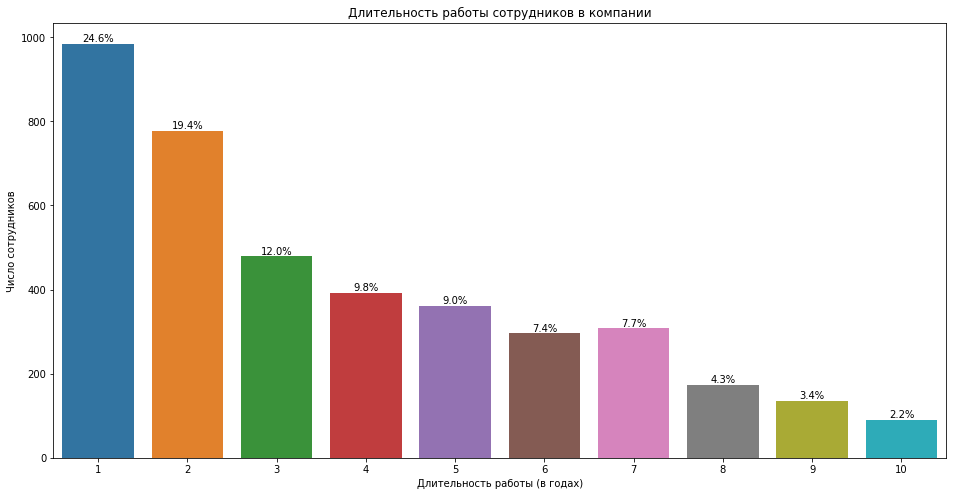

In [144]:
# Построим графики для количественных признаков датафрейма.
# Построим столбчатую диаграмму распределения длительности работы сотрудников в компании.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='employment_years', data = train_quit)
total = train_quit['employment_years'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Длительность работы сотрудников в компании')
plt.xlabel('Длительность работы (в годах)')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающее подозрений, похожее на тренировочные данные из задачи 1.

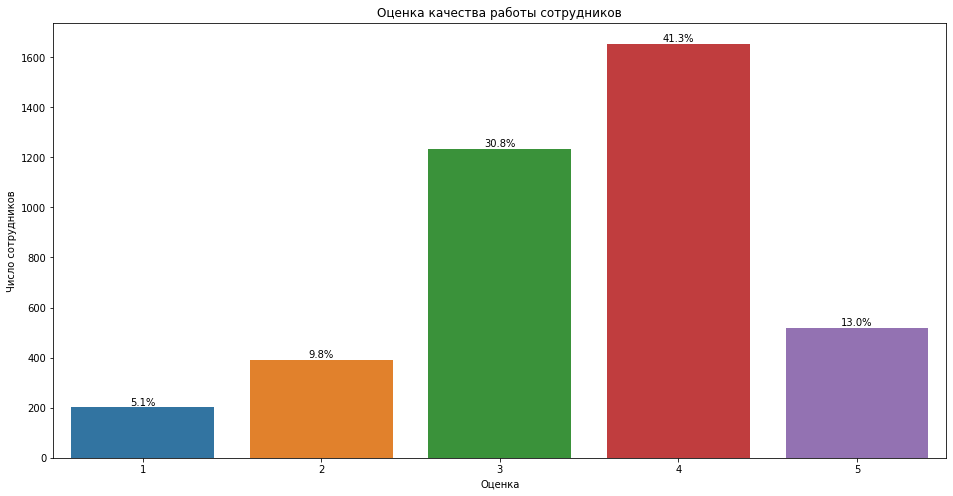

In [146]:
# Построим столбчатую диаграмму распределения оценок качества работы сотрудников, данных руководителями.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='supervisor_evaluation', data = train_quit)
total = train_quit['supervisor_evaluation'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Оценка качества работы сотрудников')
plt.xlabel('Оценка')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающее подозрений, похожее на тренировочные данные из задачи 1.

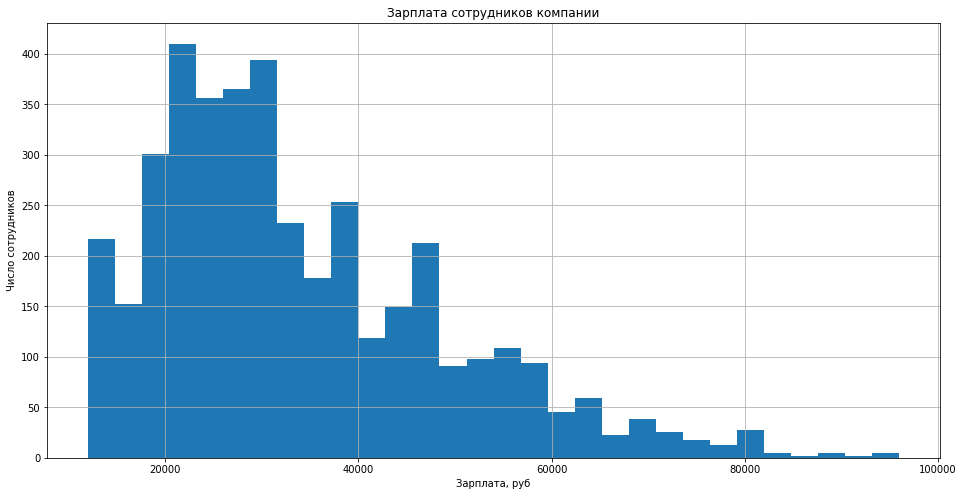

In [87]:
# Построим гистограмму распределения зарплат сотрудников компании.
train_quit['salary'].hist(figsize=(16, 8), bins=30)
plt.title('Зарплата сотрудников компании')
plt.xlabel('Зарплата, руб')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, не вызывающее подозрений, похожее на тренировочные данные из задачи 1. Также имеются выбросы, которые мы не будем убирать в виду того, что они действительно возможны.

In [88]:
# Проанализируем распределение категоральных признаков.
# Начнем с отделов, в которых работают сотрудники.
train_quit['dept'].value_counts()

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

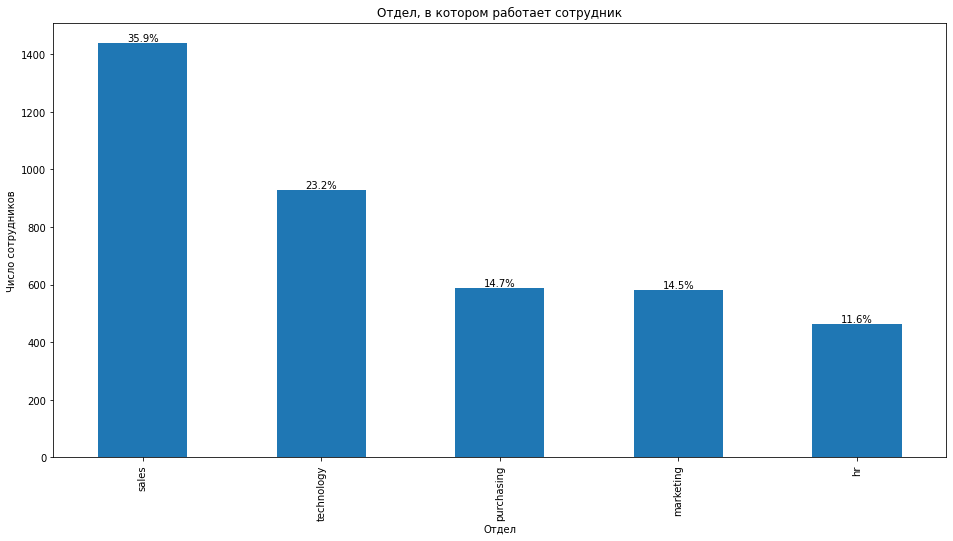

In [147]:
# Построим столбчатую диаграмму распределения по отделам.
plt.figure(figsize=(16, 8))
ax = train_quit['dept'].value_counts().plot(kind='bar')
total = train_quit['dept'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Отдел, в котором работает сотрудник')
plt.xlabel('Отдел')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим, что самым большим отделом является отдел продаж. Наименьшим является HR.

In [90]:
# Рассмотрим уровень занимаемой сотрудниками должности.
train_quit['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

<Axes: title={'center': 'Уровень занимаемой сотрудниками должности'}, ylabel='level'>

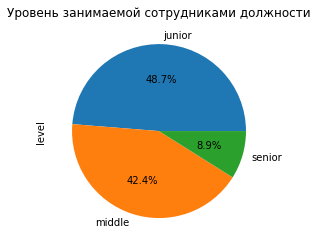

In [91]:
# Построим круговую диаграмму распределения уровней занимаемой должности.
train_quit['level'].value_counts().plot(kind='pie', title='Уровень занимаемой сотрудниками должности', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 48.7 - junior, 42.4 - middle и 8.9 - senior.

In [92]:
# Рассмотрим уровень загруженности сотрудников.
train_quit['workload'].value_counts()

medium    2118
low       1208
high       674
Name: workload, dtype: int64

<Axes: title={'center': 'Уровень загруженности сотрудников'}, ylabel='workload'>

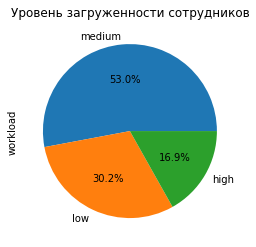

In [93]:
# Построим круговую диаграмму распределения уровней загруженности.
train_quit['workload'].value_counts().plot(kind='pie', title='Уровень загруженности сотрудников', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 53 - средний, 30.2 - низкий и 16.9 - высокий уровень.

In [94]:
# Рассмотрим распределение повышений в прошлом году.
train_quit['last_year_promo'].value_counts()

no     3887
yes     113
Name: last_year_promo, dtype: int64

<Axes: title={'center': 'Распределение повышений в прошлом году'}, ylabel='last_year_promo'>

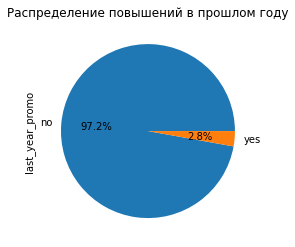

In [95]:
# Построим круговую диаграмму распределения повышений.
train_quit['last_year_promo'].value_counts().plot(kind='pie',
                                                     title='Распределение повышений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 97.2 к 2.8 с перевесом в пользу отсутствия повышения.

In [96]:
# Рассмотрим распределение нарушений сотрудниками трудового договора за последний год.
train_quit['last_year_violations'].value_counts()

no     3455
yes     545
Name: last_year_violations, dtype: int64

<Axes: title={'center': 'Распределение нарушений в прошлом году'}, ylabel='last_year_violations'>

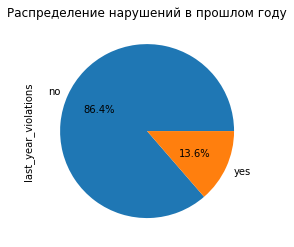

In [97]:
# Построим круговую диаграмму распределения повышений.
train_quit['last_year_violations'].value_counts().plot(kind='pie',
                                                      title='Распределение нарушений в прошлом году', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 86.4 к 13.6 с перевесом в пользу отсутствия нарушений.

In [98]:
# Рассмотрим распределение увольнений сотрудников из компании.
train_quit['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

<Axes: title={'center': 'Распределение увольнений сотрудников из компании'}, ylabel='quit'>

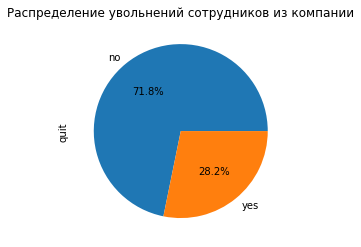

In [99]:
# Построим круговую диаграмму распределения увольнений сотрудников из компании.
train_quit['quit'].value_counts().plot(kind='pie',
                                       title='Распределение увольнений сотрудников из компании', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 71.8 к 28.2 с перевесом в пользу продолжения работы в компании.

#### test_target_quit.csv

In [100]:
# Рассмотрим распределение увольнений сотрудников из компании.
test_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

<Axes: title={'center': 'Распределение увольнений сотрудников из компании'}, ylabel='quit'>

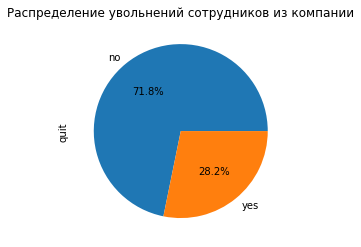

In [101]:
# Построим круговую диаграмму распределения увольнений сотрудников из компании.
test_quit['quit'].value_counts().plot(kind='pie',
                                       title='Распределение увольнений сотрудников из компании', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 71.8 к 28.2 с перевесом в пользу продолжения работы в компании.

#### Корреляционный анализ тренировочной выборки

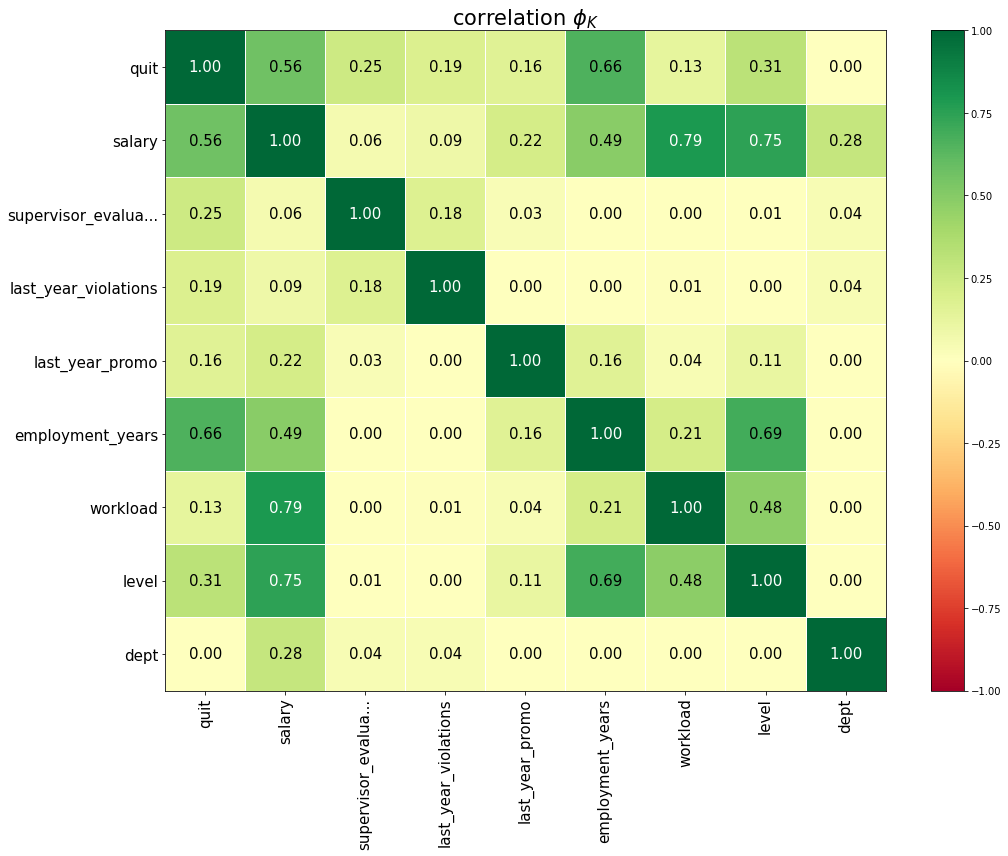

In [102]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции признаков тренировочной выборки.
cdf = train_quit.drop(columns=['id'])

# Составим список интервальных признаков.
interval_cols = ['salary']

# Вычислим коэффициенты корреляции phi для датафрейма.
phik_overview = cdf.phik_matrix(interval_cols=interval_cols)

# Визуализируем тепловую карту коэффициентов корреляции.
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Описание данных:** Видим корреляцию уровня загруженности с зарплатой и уровня должности с зарплатой, однако, говорить о мультиколлинеарности рано.

#### Корреляционный анализ тестовой выборки

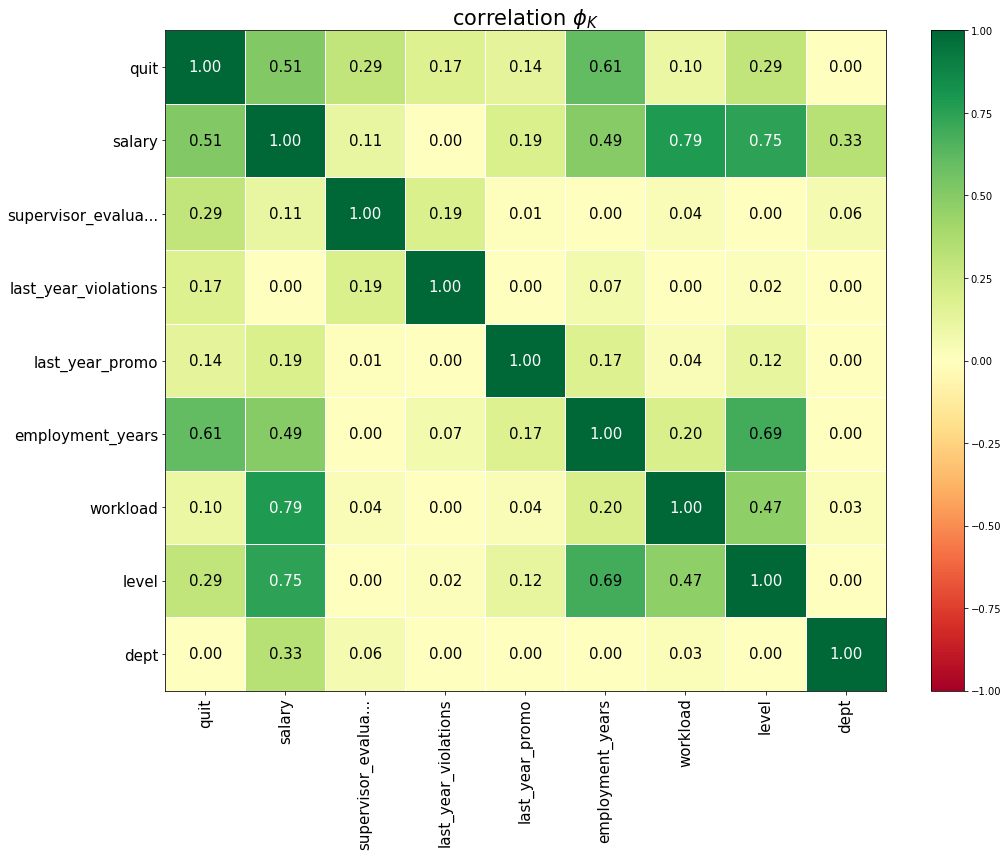

In [103]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции признаков тестовой выборки.
ddf = test_features.merge(test_quit, on='id', how='inner').drop(columns=['id'])

# Составим список интервальных признаков.
interval_cols = ['salary']

# Вычислим коэффициенты корреляции phi для датафрейма.
phik_overview = ddf.phik_matrix(interval_cols=interval_cols)

# Визуализируем тепловую карту коэффициентов корреляции.
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Описание данных:** Видим корреляцию уровня загруженности с зарплатой и уровня должности с зарплатой, как и в тренировочных данных. Однако, говорить о мультиколлинеарности рано.

#### Составление портрета уволившегося сотрудника

In [104]:
# Разделим тренировочную выборку на ушедших и оставшихся сотрудников.
train_stay = train_quit.loc[train_quit['quit'] == 'no']
train_left = train_quit.loc[train_quit['quit'] == 'yes']

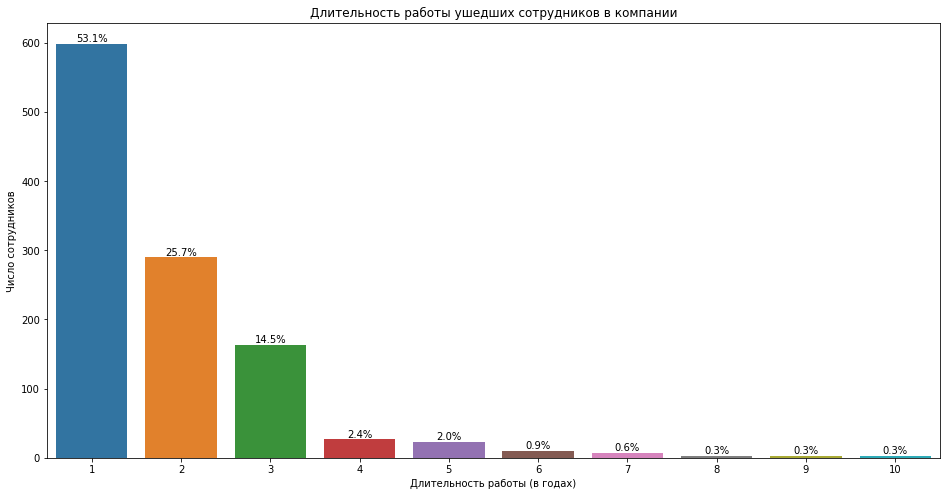

In [105]:
# Построим столбчатую диаграмму распределения длительности работы ушедших сотрудников в компании.
plt.figure(figsize=(16,8))
ax = sns.countplot(x='employment_years', data=train_left)
total = train_left['employment_years'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Длительность работы ушедших сотрудников в компании')
plt.xlabel('Длительность работы (в годах)')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим смещение данных относительно общих в сторону меньшей длительности работы.

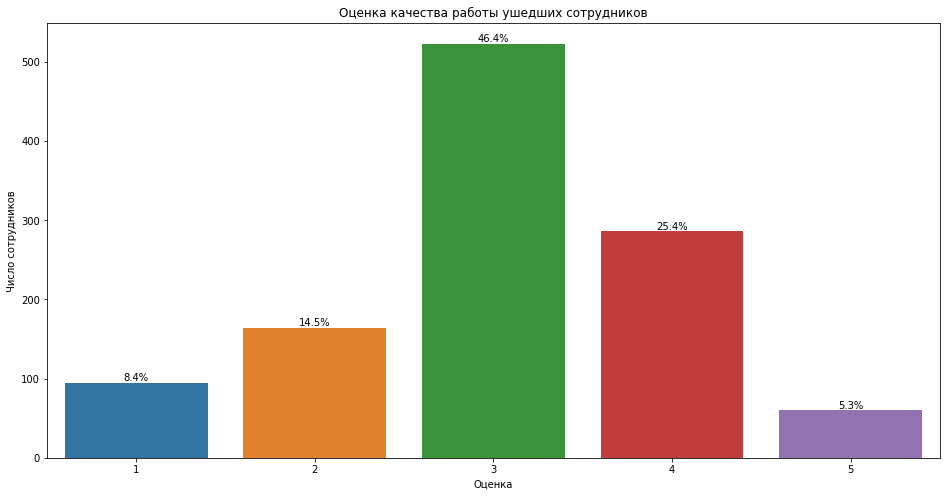

In [133]:
# Построим столбчатую диаграмму распределения оценок качества работы ушедших сотрудников, данных руководителями.
plt.figure(figsize=(16,8))
ax = sns.countplot(x ='supervisor_evaluation', data = train_left)
total = train_left['supervisor_evaluation'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Оценка качества работы ушедших сотрудников')
plt.xlabel('Оценка')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим смещение данных относительно общих в сторону оценки 3.

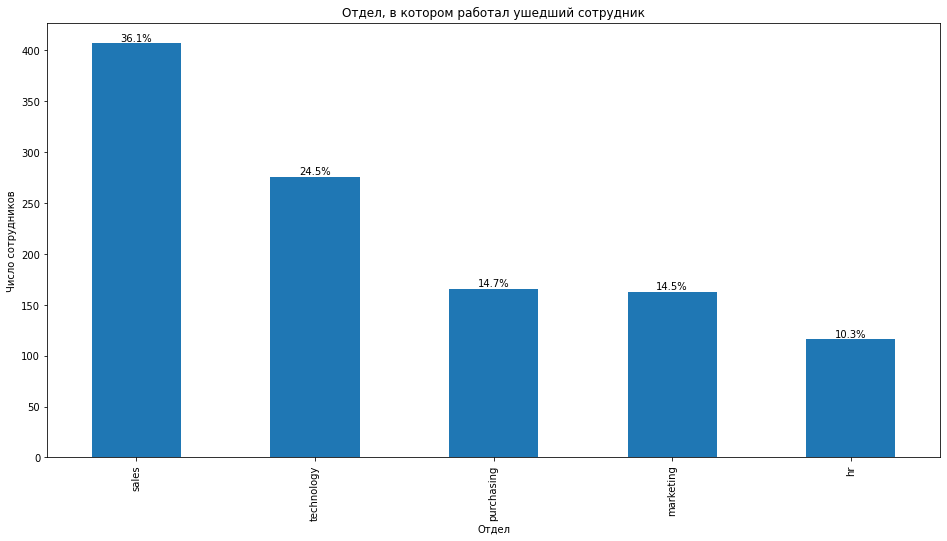

In [136]:
# Построим столбчатую диаграмму распределения ушедших сотрудников по отделам.
plt.figure(figsize=(16, 8))
ax = train_left['dept'].value_counts().plot(kind='bar')
total = train_left['dept'].count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.title('Отдел, в котором работал ушедший сотрудник')
plt.xlabel('Отдел')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим, что распределние ушедших сотрудников похоже на общее, значит, внутри отделов нет отдельно влияющих факторов на отток сотрудников.

In [108]:
# Рассмотрим уровень загруженности ушедших сотрудников.
train_left['workload'].value_counts()

low       519
medium    488
high      121
Name: workload, dtype: int64

<Axes: title={'center': 'Уровень загруженности ушедших сотрудников'}, ylabel='workload'>

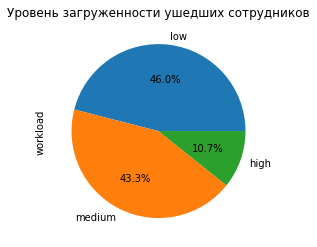

In [109]:
# Построим круговую диаграмму распределения уровней загруженности ушедших сотрудников.
train_left['workload'].value_counts().plot(kind='pie', title='Уровень загруженности ушедших сотрудников', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 46 - низкий, 43.3 - средний и 10.7 - высокий уровень.

In [110]:
# Сравним среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
salary_stay = train_stay['salary'].mean()
salary_left = train_left['salary'].mean()
print(f'Средняя зарплата оставшихся сотрудников: {salary_stay}')
print(f'Средняя зарплата ушедших сотрудников: {salary_left}')

Средняя зарплата оставшихся сотрудников: 37702.22841225627
Средняя зарплата ушедших сотрудников: 23885.106382978724


**Описание данных:** Видим, что средняя зарплата ушедших сотрудников ниже, чем оставшихся.

In [111]:
# Рассмотрим уровень занимаемой ушедшими сотрудниками должности.
train_left['level'].value_counts()

junior    1003
middle     108
senior      17
Name: level, dtype: int64

<Axes: title={'center': 'Уровень занимаемой ушедшими сотрудниками должности'}, ylabel='level'>

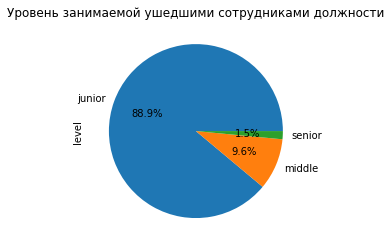

In [112]:
# Построим круговую диаграмму распределения уровней занимаемой ушедшими сотрудниками должности.
train_left['level'].value_counts().plot(kind='pie',
                                        title='Уровень занимаемой ушедшими сотрудниками должности', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении: 88.9 - junior, 9.6 - middle и 2.5 - senior.

In [113]:
# Рассмотрим распределение повышений ушедших сотрудников в прошлом году.
train_left['last_year_promo'].value_counts()

no     1127
yes       1
Name: last_year_promo, dtype: int64

<Axes: title={'center': 'Распределение повышений ушедших сотрудников в прошлом году'}, ylabel='last_year_promo'>

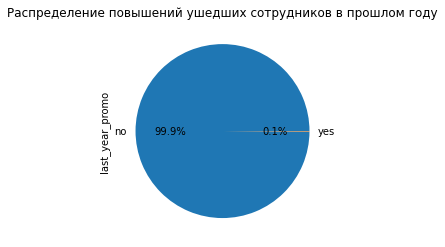

In [114]:
# Построим круговую диаграмму распределения повышений.
train_left['last_year_promo'].value_counts().plot(kind='pie',
                                                     title='Распределение повышений ушедших сотрудников в прошлом году',
                                                  autopct='%1.1f%%')

**Описание данных:** Видим всего одно повышение сотрудника.

In [115]:
# Рассмотрим распределение нарушений ушедшими сотрудниками трудового договора за последний год.
train_left['last_year_violations'].value_counts()

no     900
yes    228
Name: last_year_violations, dtype: int64

<Axes: title={'center': 'Распределение нарушений ушедшими сотрудниками в прошлом году'}, ylabel='last_year_violations'>

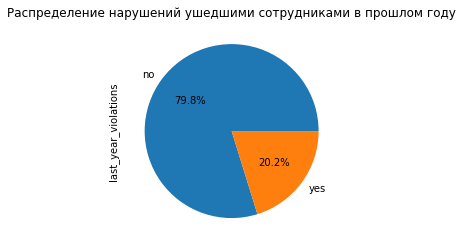

In [116]:
# Построим круговую диаграмму распределения повышений.
train_left['last_year_violations'].value_counts().plot(kind='pie',
                                                      title='Распределение нарушений ушедшими сотрудниками в прошлом году',
                                                       autopct='%1.1f%%')

**Описание данных:** Видим увеличение в отношении нарушений - с 13.6 до 20.2.

**Промежуточный вывод:** Портрет уволившегося сотрудника выглядит примерно так:
- Зачастую малый срок работы в компании.
- В среднем хуже оценен руководителем.
- Распределение по отделам похоже на общее.
- Уровень загруженности ушедших сотрудников ниже общего.
- Зарплата ушедших сотрудников ниже, чем оставшихся.
- Уровень занимаемой должности ниже, сильно смещен в сторону junior.
- За одним исключением, отсутствие повышений.
- Больше нарушений трудового договора.

#### Распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников

In [117]:
# Соберем таблицу из тестовых данных для исследования.
sdf = test_sat.merge(test_quit, on='id', how='inner')
sdf.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [118]:
# Разделим тестовую выборку на ушедших и оставшихся сотрудников.
test_stay = sdf.loc[sdf['quit'] == 'no']
test_left = sdf.loc[sdf['quit'] == 'yes']

In [119]:
test_stay.describe()

,id,job_satisfaction_rate
count,1436.000000,1436.000000
mean,548680.699164,0.612040
std,254730.637881,0.199367
min,100298.000000,0.030000
25%,327477.750000,0.500000
50%,546372.000000,0.660000
75%,761578.500000,0.760000
max,998900.000000,1.000000


In [120]:
test_left.describe()

,id,job_satisfaction_rate
count,564.000000,564.000000
mean,563164.792553,0.387713
std,251523.775926,0.185784
min,103221.000000,0.040000
25%,358969.500000,0.240000
50%,554657.000000,0.370000
75%,781640.250000,0.492500
max,999029.000000,0.970000


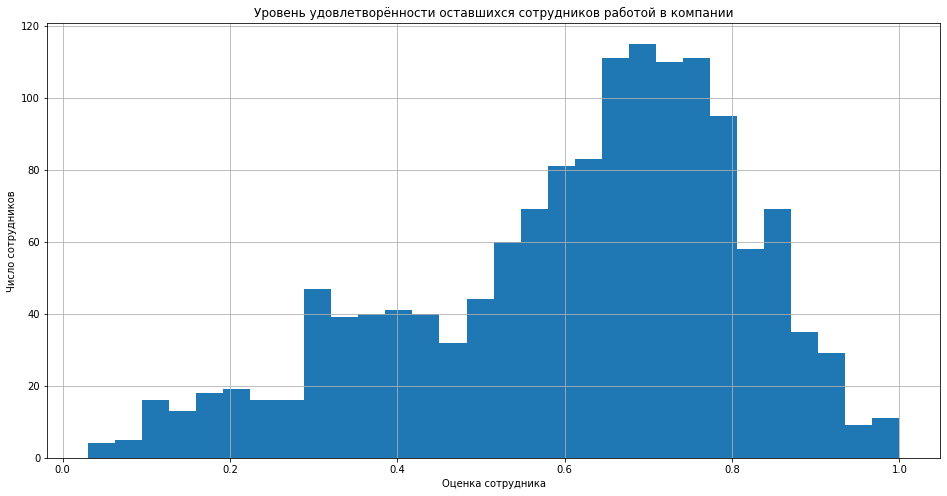

In [121]:
# Построим гистограмму уровня удовлетворённости оставшегося сотрудника работой в компании.
test_stay['job_satisfaction_rate'].hist(figsize=(16, 8), bins=30)
plt.title('Уровень удовлетворённости оставшихся сотрудников работой в компании')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, похожее на нормальное, со сдвигом вправо.

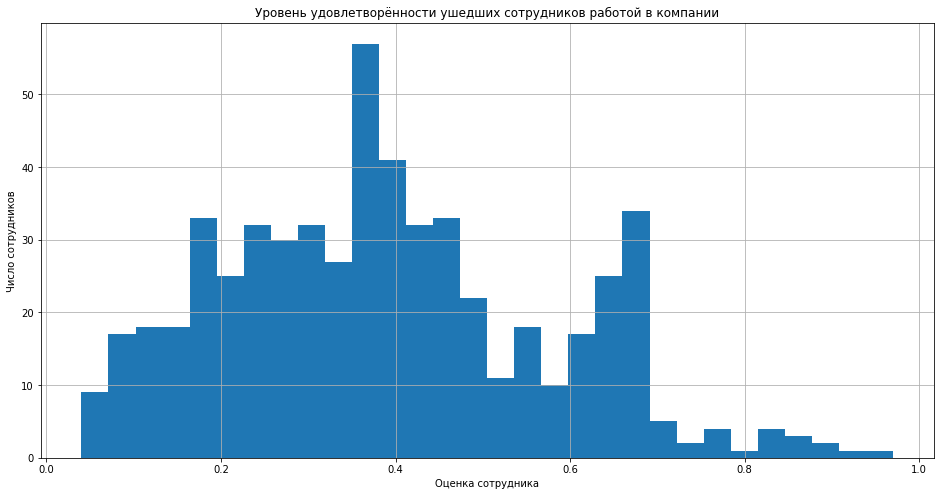

In [122]:
# Построим гистограмму уровня удовлетворённости ушедшего сотрудника работой в компании.
test_left['job_satisfaction_rate'].hist(figsize=(16, 8), bins=30)
plt.title('Уровень удовлетворённости ушедших сотрудников работой в компании')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Число сотрудников')
plt.show()

**Описание данных:** Видим распределение, похожее на нормальное, со сдвигом влево.

**Промежуточный вывод:** Действительно, значения удовлетворенности работой отличаются для оставшихся и уволившихся сотрудников: 0.66 - медианная оценка оставшихся против 0.37 для ушедших сотрудников.

### Добавление нового входного признака

In [123]:
# Добавим предсказанный признак удовлетворенности работой к датафреймам.
train_quit['job_satisfaction_rate'] = search.predict(train_quit.drop(['quit'], axis = 1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.638750
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.823158
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.333750
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [124]:
test_features['job_satisfaction_rate'] = search.predict(test_features)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.648750
3,418655,sales,middle,low,6,no,no,4,19200,0.663750
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


### Подготовка данных

In [125]:
# Преобразуем значения целевого признака с помощью LabelEncoder().
labelencoder = LabelEncoder()
# Целевой признак тренировочной выборки.
train_quit['quit'] = labelencoder.fit_transform(train_quit['quit'])
# Для преобразования тестовой выборки объединим и впоследствии разделим тестовый датафрейм.
tdf = test_features.merge(test_quit, on='id', how='inner')
tdf['quit'] = labelencoder.transform(tdf['quit'])

In [126]:
# Обозначим новые выборки.
X = train_quit.drop(['id', 'quit'], axis = 1)
y = train_quit['quit']

In [127]:
# Создадим новые списки с названиями признаков.
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

Пайплайны подготовки возьмем из первой задачи.

### Обучение модели

In [128]:
# Создадим новый итоговый пайплайн: подготовка данных и модель.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [129]:
# Создадим новый param_grid.
param_grid= [
    # Словарь для модели DecisionTreeClassifier():
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели KNeighborsClassifier():
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Словарь для модели LogisticRegression():
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Словарь для модели SVC():
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability=True
        )],
        'models__C': range(1, 10),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [130]:
# Подберем лучшую модель и ее параметры.
r_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
r_search.fit(X, y)

print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', r_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [131]:
# Проверим модель на тестовой выборке.
X_test = tdf.drop(['id', 'quit'], axis = 1)
y_test = tdf['quit']

# Посчитаем площадь ROC-кривой по вероятностям классов.
probabilities = r_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.911922277208163


### Выводы

Качество модели, согласно условию, подбирали, основываясь на метрике ROC-AUC (receiver operating characteristic, area under the curve). Критерий успеха: площадь ROC-кривой ≥0.91 на тестовой выборке.

В результате рандомизированного поиска по параметрам отобрали модель KNeighborsClassifier с параметром n_neighbors=27. Эта модель показала лучшие результаты метрики ROC-AUC на тренировочной выборке: 0.91. Так как наши данные не линейны, имеют больше категоральных признаков, чем количественных, и их сложно разделять, стоит использовать kNN.

## Общий вывод

### Задача 1

**Цель исследования:** Отобрали модель машинного обучения, которая предсказывает уровень удовлетворённости сотрудника работой.

**Предобработка данных:** Проверили данные на дубликаты и пропуски, явные повторы обнаружены не были. Привели данные к одному правильному виду и заполнили пропуски в пайплайне.

**Исследовательский анализ данных:** Провели статистический и корреляционный анализ всех признаков датафреймов, построили графики для каждого признака. Необычные выбросы и мультиколлинеарность обнаружены не были.

**Подготовка данных и обучение моделей:** Обозначили выборки, взяв в качестве целевого признака удовлетворённости сотрудника работой, а в качестве входных - все остальные.

Качество модели, согласно условию, подбирали, основываясь на метрике SMAPE (symmetric mean absolute percentage error), для которой создали свою функцию. Критерий успеха: SMAPE ≤15 на тестовой выборке.

В результате рандомизированного поиска по параметрам отобрали модель DecisionTreeRegressor с параметрами max_depth=19, min_samples_leaf=2, min_samples_split=9. Эта модель показала лучшие результаты метрики SMAPE на тренировочной выборке: 13.46. Когда в данных больше категориальных признаков, чем количественных, лучше использовать модель дерева решений, чем линейной регрессии.

### Задача 2

**Цель исследования:** Отобрали модель машинного обучения, которая предсказывает возможное увольнение сотрудника из компании.

**Предобработка данных:** Проверили данные на дубликаты и пропуски, явные повторы и пропуски обнаружены не были. Привели данные к одному правильному виду.

**Исследовательский анализ данных:** Провели статистический и корреляционный анализ всех признаков датафреймов, построили графики для каждого признака. Необычные выбросы и мультиколлинеарность обнаружены не были.

Составили портрет уволившегося сотрудника:
- Зачастую малый срок работы в компании.
- В среднем хуже оценен руководителем.
- Распределение по отделам похоже на общее.
- Уровень загруженности ушедших сотрудников ниже общего.
- Зарплата ушедших сотрудников ниже, чем оставшихся.
- Уровень занимаемой должности ниже, сильно смещен в сторону junior.
- За одним исключением, отсутствие повышений.
- Больше нарушений трудового договора.

Кроме того, рассмотрели распределение уровня удовлетворённости ушедших и оставшихся сотрудников работой, увидели взаимосвязь признака с целевым.

**Подготовка данных и обучение моделей:** Обозначили выборки, взяв в качестве целевого признака уволился ли сотрудник или нет и закодировав его, а в качестве входных - все остальные. К исходным данным добвили новый входной признак - предсказанный моделью МО из первой задачи признак удовлетворенности сотрудника работой.

Качество модели, согласно условию, подбирали, основываясь на метрике ROC-AUC (receiver operating characteristic, area under the curve). Критерий успеха: площадь ROC-кривой ≥0.91 на тестовой выборке.

В результате рандомизированного поиска по параметрам отобрали модель KNeighborsClassifier с параметром n_neighbors=27. Эта модель показала лучшие результаты метрики ROC-AUC на тренировочной выборке: 0.91. Так как наши данные не линейны, имеют больше категоральных признаков, чем количественных, и их сложно разделять, стоит использовать kNN.

### Предложения и рекомендации

- Судя по исследовательскому анализу кадров, имеет место текучесть новых кадров - возможно, стоит уделить их обучению и лояльности компании больше времени. Например, отправлять их на обучающие курсы, пересмотреть социальный пакет или проводить корпоративные мероприятия.
- У работников компании редки случаи повышения. Возможно, стоит ввести больше промежуточных должностей - это добавит сотрудникам мотивации, а новая должность должна повысить уровень их удовлетворенности. Кроме того, это может помочь организовать рабочий процесс для новых кадров.
- Возможно, низкая зарплата junior сотрудников или рабочие условия в отделах сказываются на удовлетворенности работой. Стоит провести дополнительные исследования, как опросы, так и независимые оценки.
- Судя по корреляционному анализу кадров, оценка сотрудника руководителем влияет на его довольство работой. Стоит обратить на это внимание, так как не известно, что является причиной чего из двух. В случае, если оценка сказывается на довольстве, возможно не стоит ее оглашать. В обратном случае, рекомендую разделить оценку на рабочие и социальные качества.